# Lick model

### This notebook is an initial attempt to model trains of licks when rats are choosing between two solutions (e.g. protein and carbohydrate)

In [61]:
import random
import numpy as np
import math
from scipy.stats import lognorm

import matplotlib as mpl
my_params = mpl.rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'

%matplotlib inline
%run helperfx

run_notebook=True

In [79]:
# Edit these values when using this notebook
use_real_data = True
simulate_data = True
fit_data = True

# set parameters for simulated data
if simulate_data:
    PP = 0.5
    lam = 200

# set bounds for fitting data
if fit_data:
    bounds = {'PP':[0, 1, 20], 'lam':[50, 2050, 20]}

    boundbins = []
    boundbins.append(np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2]))
    boundbins.append(np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][1]/bounds['lam'][2]))

if use_real_data and simulate_data:
    print('Over-riding simulate_data because use_real_data is selected.')
    simulate_data = False

Over-riding simulate_data because use_real_data is selected.


In [80]:
# This function will be called when simulating test data and data for performing fits

def runmodel(PP, lam, nruns):
    
    # Create system with vars of interest
    System = {}
    System['PP'] = PP
    System['lam'] = lam
    System['licksinburst'] = 0
    
    # Initializes array for storing data
    output = [0.5]

    for i in range(1, nruns):
        update_func(System, output)
    
    return output

In [81]:
def update_func(System, licks):
    pp = System['PP']
    lam = System['lam']
    x = System['licksinburst']
    
    if licks[-1] == 0.5:
            if random.random() < pp:
                licks.append(1)            
            else:
                licks.append(0)
            System['licksinburst'] = x+1
    else:
        p_cont = -(1/lam)*x+0.95
        if random.random() < p_cont:           
            licks.append(licks[-1])
            System['licksinburst'] = x+1
        else:
            licks.append(0.5)
            System['licksinburst'] = 0          

In [82]:
def analyse_licks(data, bins):
    
    caslicks = len([x for x in data if x == 1])
    maltlicks = len([x for x in data if x == 0])
    realPP = caslicks/(caslicks + maltlicks)
    
    burstarray = []
    tmp = []
    for i, x in enumerate(data):
        if x == 0.5:
            burstarray.append(tmp)
            tmp = []
        else:
            tmp.append(x)
    
    bursts = []
    hists = []
    cumsums = []
    cumsums_norm = []
    
    for code in [0, 1]: 
        b = [len(x) for x in burstarray[1:] if x[0]==code]
        h = np.histogram(b, bins=bins) # add binsize
        cs = np.cumsum(h[0])

        bursts.append(b)
        hists.append(h)
        cumsums.append(cs)
        
    cumsums_norm.append([(x/cumsums[0][-1])*(1-realPP) for x in cumsums[0]]) # makes cumsums norm'd to toal licks
    cumsums_norm.append([(x/cumsums[1][-1])*(realPP) for x in cumsums[1]])
    
    return ({'licks':data, 'bursts':bursts, 'hists':hists, 'cumsums':cumsums, 'cumsums_norm':cumsums_norm, 'realPP':realPP })

In [83]:
def fit(lickdata, boundbins, histbins, nruns=1000, fittype='hist'):
    print('Fitting data using bounds provided.')

    nPP = len(boundbins[0])
    nlam = len(boundbins[1])
    
    grid = np.empty((nPP,nlam,))
    
    pp_matrix = boundbins[0]
    lam_matrix = boundbins[1]
    
    for pp_idx, pp in enumerate(pp_matrix):
        for lam_idx, lam in enumerate(lam_matrix):
            comparison_data = runmodel(pp, lam, nruns)
            licks_to_fit = analyse_licks(comparison_data, histbins)
            
            #work out loglik for hist bins using compare function and place this value in the grid
            
            diffs = []
            
            # To use histograms for comparison with model
            if fittype == 'hist':
                for bottle in [0, 1]:
                    data = lickdata['hists'][bottle][0]
                    comp = licks_to_fit['hists'][bottle][0]         
                    diffs.append(sum([np.abs(x-y) for x,y in zip(data, comp)]))
            else:
            # To use cumulative distributions for comparison with model
                for bottle in [0, 1]:
                    data = lickdata['cumsums'][bottle]
                    comp = licks_to_fit['cumsums'][bottle]       
                    diffs.append(sum([np.abs(x-y) for x,y in zip(data, comp)]))
            
            grid[pp_idx, lam_idx] = sum(diffs)
    
    grid = 1/grid
    
    tmp = np.sum(grid, axis=1)
    pp_marglik = tmp/sum(tmp)
    pp_ML = boundbins[0][np.argmax(pp_marglik)]
    pp_EV = sum(boundbins[0]*pp_marglik)
    
    tmp = np.sum(grid, axis=0)
    lam_marglik = tmp/sum(tmp)
    lam_ML = boundbins[1][np.argmax(lam_marglik)]
    lam_EV = sum(boundbins[1]*lam_marglik)
    
    fitted = {'grid':grid,
              'pp_marglik': pp_marglik, 'pp_ML':pp_ML, 'pp_EV':pp_EV,
              'lam_marglik': lam_marglik, 'lam_ML':lam_ML, 'lam_EV':lam_EV}
    
    return fitted

In [84]:
# Code to get data to be tested - either real or simulated - to be used when testing new parameters, functions etc

if run_notebook:   

    nruns=5000
    histbins = np.arange(0,100)
    
# in future this will allow one to select subjects and experiments by including arguments for medfile location etc    
    if use_real_data:
        %run extractlicks.ipynb
        ratkey = 'IPP3.4'
        licks = test1_data_PR[ratkey]

    if simulate_data:
        print('Simulating data with values: PP={0} and lamda={1}'.format(PP,lam))
        ratkey = 'simulated_PP={0}_lambda={1}'.format(PP,lam)
        licks = runmodel(PP, lam, nruns)

    try:
        test1_data_NR.keys()
    except NameError:
        print('Data not loaded from file so cannot show keys')

    lickdata = analyse_licks(licks, histbins)

<Figure size 432x288 with 0 Axes>

Extracted licks from Med data


Fitting data using bounds provided.


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars


Estimated PP= 0.5137450419835035  and estimated lambda= 1174.5650952792412  using EV
Estimated PP= 0.55  and estimated lambda= 1792.5  using ML


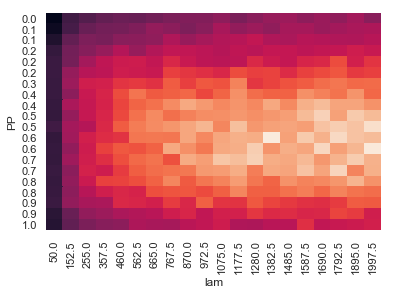

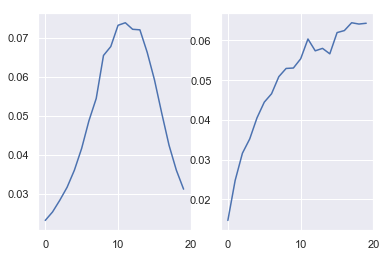

In [85]:
# Plots fitted data

if run_notebook and fit_data:
    nruns = len(licks)
    fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')

    gridscores = fitted['grid']

    pp_matrix = np.arange(bounds['PP'][0], bounds['PP'][1], bounds['PP'][1]/bounds['PP'][2])
    lam_matrix = np.arange(bounds['lam'][0], bounds['lam'][1], bounds['lam'][1]/bounds['lam'][2])

    pp_vals = ["{:.1f}".format(x) for x in pp_matrix]
    lam_vals = ["{:.1f}".format(x) for x in lam_matrix]

    import seaborn as sns; sns.set()
    ax = sns.heatmap(np.log(gridscores), cbar=False, xticklabels=lam_vals, yticklabels=pp_vals)
    ax.set_xlabel('lam')
    ax.set_ylabel('PP')

    f, ax = plt.subplots(ncols=2)
    ax[0].plot(fitted['pp_marglik'])
    ax[1].plot(fitted['lam_marglik'])

    print('Estimated PP=', fitted['pp_EV'], ' and estimated lambda=', fitted['lam_EV'], ' using EV')
    print('Estimated PP=', fitted['pp_ML'], ' and estimated lambda=', fitted['lam_ML'], ' using ML')

In [86]:
def timecourseFig(lickdata, ax=[]):

    x1 = [i for i, x in enumerate(lickdata['licks']) if x == 1]
    x2 = [i for i, x in enumerate(lickdata['licks']) if x == 0]

    y1 = [1]*len(x1)
    y2 = [0]*len(x2)

    ax.plot(x1,y1, 'x')
    ax.plot(x2,y2, 'x')

    # plots real PP
    x1=0; x2=len(lickdata['licks']); y=lickdata['realPP']
    ax.plot([x1, x2], [y, y], linestyle='dashed')
    ax.text(x2,y,'Real PP', va='center' )
    
    if fit_data:
        print('Fitted')
        ax.plot(np.arange(0,len(licks)),[fitted['pp_EV']]*len(licks), 'r', linestyle='dashed')

    #ax.plot(smooth(licks, 50), 'b')
    ax.plot(smooth2(lickdata['licks'], 50), 'r')

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('Licks')
    ax.set_ylabel('PP')
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Malto', '0.5', 'Casein'])

def histoFig(lickdata, smooth=0, ax=[]):
    
    for index, color in zip([1,0], ['blue', 'orange']):
        x = lickdata['hists'][index][1][1:-1]
        y = lickdata['hists'][index][0][1:]
        
        
        if smooth > 0:
            ax.plot(smooth2(y, smooth))
        else:
            ax.plot(x,y, c=color)
            
        ax.set_xlabel('Licks in burst')
        ax.set_ylabel('Frequency')
        
    cas = lickdata['bursts'][1]
    malt = lickdata['bursts'][0]
    meanCas = 'Casein={:} total bursts\nwith {:.1f} licks/burst'.format(len(cas), np.mean(cas))
    
    meanMalto = 'Malto={:} total bursts\nwith {:.1f} licks/burst'.format(len(malt), np.mean(malt))
    ax.text(0.95, 0.95, meanCas+'\n \n'+meanMalto,
            transform=ax.transAxes, ha='right', va='top')

def cumsumFig(lickdata, normed=False, ax=[]):
    
    if normed:
        datatoplot = lickdata['cumsums_norm']
        ylabel = 'Normd cum. frequency'
    else:
        datatoplot = lickdata['cumsums']
        ylabel = 'Cumulative frequency'
    
    for index, color in zip([1,0], ['blue', 'orange']):
        ax.plot(datatoplot[index])
        
    ax.set_xlabel('Licks in burst')
    ax.set_ylabel(ylabel)

def makeSessionFig(lickdata, ratkey='', savefig=False, savefolder=''):
    f = plt.figure(figsize=(12,7))
    f.suptitle(ratkey)
    gs = gridspec.GridSpec(2, 3, hspace=0.3, wspace=0.3)

    ax1 = f.add_subplot(gs[0, :])
    timecourseFig(lickdata, ax=ax1)

    ax2 = f.add_subplot(gs[1,0])
    histoFig(lickdata, ax=ax2)

    ax3 = f.add_subplot(gs[1,1])
    cumsumFig(lickdata, ax=ax3)
    
    ax4 = f.add_subplot(gs[1,2])
    cumsumFig(lickdata, normed=True, ax=ax4)

    if savefig:
        f.savefig(savefolder+ratkey+'_sessionfig.png')


Fitted


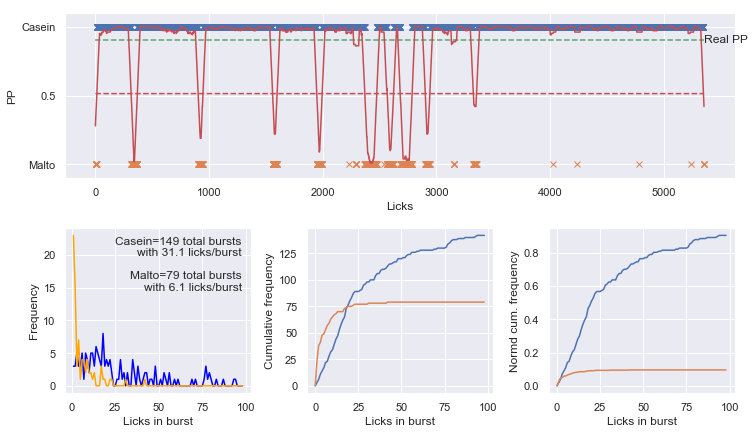

In [87]:
if run_notebook:

    makeSessionFig(lickdata, savefig=False)

In [12]:
# Cell to extract data from all rat

assemble_all_rats=False

if assemble_all_rats:
    %run extractlicks.ipynb

    # Data for NR rats
    NRhists_cas = []
    NRhists_malt = []
    NR_PPs = []

    for ratkey in test1_data_NR.keys():
        licks = test1_data_NR[ratkey]
        lickdata = analyse_licks(licks, histbins)
        NRhists_cas.append(lickdata['hists'][1][0])
        NRhists_malt.append(lickdata['hists'][0][0])
        NR_PPs.append(lickdata['realPP'])

        makeSessionFig(lickdata, savefig=True)


In [13]:
# Data for NR rats

if assemble_all_rats:
    PRhists_cas = []
    PRhists_malt = []
    PR_PPs = []

    for ratkey in test1_data_PR.keys():
        licks = test1_data_PR[ratkey]
        lickdata = analyse_licks(licks, histbins)
        PRhists_cas.append(lickdata['hists'][1][0])
        PRhists_malt.append(lickdata['hists'][0][0])
        PR_PPs.append(lickdata['realPP'])

        makeSessionFig(lickdata, savefig=True)

In [14]:
if assemble_all_rats:

    try:
        current_palette = sns.color_palette()
    except NameError:
        current_palette = ['blue', 'orange']

    NRhists_cas_avg = np.sum(NRhists_cas, axis=0)
    NRhists_malt_avg = np.sum(NRhists_malt, axis=0)

    f, ax = plt.subplots(nrows=2)
    ax[0].plot(NRhists_cas_avg)
    ax[0].plot(NRhists_malt_avg)

    ax[0].set_xlabel('Licks in burst')
    ax[0].set_ylabel('Frequency')
    ax[0].text(0.9, 0.9, 'Casein', color=current_palette[1], transform=ax[0].transAxes, ha='right', va='top')
    ax[0].text(0.9, 0.8, 'Maltodextrin', color=current_palette[0], transform=ax[0].transAxes, ha='right', va='top')

    savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
    f.savefig(savefolder+'allNR_hist.png')


In [15]:
if assemble_all_rats:

    histbins = lickdata['hists'][1][1]

    NRhists_cas_avg_product = [x*n for x,n in zip(NRhists_cas_avg[1:], histbins[1:])]

    plt.plot(NRhists_cas_avg_product)

30 30


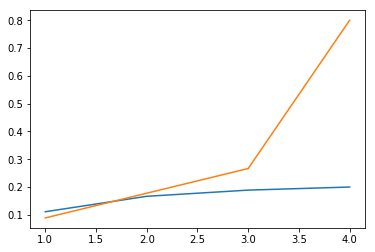

In [16]:
aaa = [10,5,2,1]
bbb = [1,1,1,6]

xxx = [1,2,3,4]
aaaN = sum([a*x for a,x in zip(aaa,xxx)])
bbbN = sum([b*x for b,x in zip(bbb,xxx)])

print(aaaN, bbbN)

aaaCS = np.cumsum(aaa)
bbbCS = np.cumsum(bbb)

ppp=0.2

aaaCS_norm = [x/aaaCS[-1]*ppp for x in aaaCS]
bbbCS_norm = [x/bbbCS[-1]*(1-ppp) for x in bbbCS]

f, ax = plt.subplots()
ax.plot(xxx,aaaCS_norm)
ax.plot(xxx,bbbCS_norm)

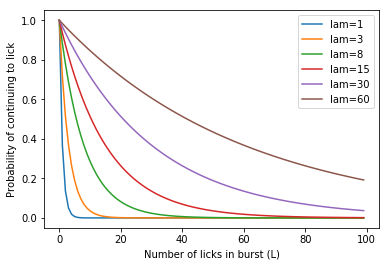

In [17]:
f, ax = plt.subplots()

lick_array = np.arange(0,100)
lam_array = [1, 3, 8, 15, 30, 60]
output_array = []

for lam in lam_array:
    output_array.append([math.exp(-x*(1/lam)) for x in lick_array])

for lam, y in zip(lam_array, output_array):
    ax.plot(lick_array, y)

ax.set_ylabel('Probability of continuing to lick')
ax.set_xlabel('Number of licks in burst (L)')
    
legend_array = ['lam='+str(lam) for lam in lam_array]
ax.legend(legend_array)

# f.savefig(savefolder+'exponential_decay.png')

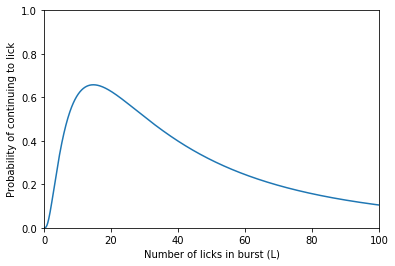

In [35]:
# To plot log-normal distribution
f, ax = plt.subplots()

x_array = np.linspace(0, 100, 1000)

alpha = 40
s=1
dist = lognorm(s, loc=0)

y = [dist.pdf(x/alpha+0)+0 for x in x_array]

ax.plot(x_array,y)
ax.set_xlim([0,100])
ax.set_ylim([0, 1])

ax.set_ylabel('Probability of continuing to lick')
ax.set_xlabel('Number of licks in burst (L)')

f.savefig(savefolder+'lognormal.png')

In [19]:
%who_ls dict

[]

In [20]:
def violinburstFig(lickdata, ax=[]):
    #current_palette = sns.color_palette()
    current_palette = ['blue', 'orange']
    
    casbursts = lickdata['bursts'][1][1:]
    maltbursts = [x*-1 for x in lickdata['bursts'][0][1:]]
    
    f, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(casbursts, color=current_palette[0])
    ax[1].plot(maltbursts, color=current_palette[1])
    
    f2, ax = plt.subplots(nrows=2, figsize=(15,4), sharex=True)
    ax[0].bar(np.arange(len(casbursts)), casbursts, color=current_palette[0])
    ax[1].bar(np.arange(len(maltbursts)),maltbursts, color=current_palette[1])
    
    #calculate 
if run_notebook:
    violinburstFig(lickdata)

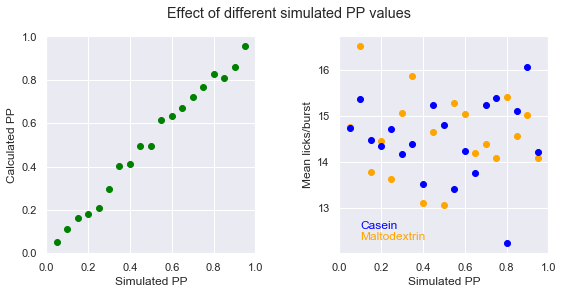

In [58]:
# Code to run simulations with different PP values

histbins = np.arange(0,100)

PP_array = np.arange(0.05,1,0.05)
lam = 100

realPP_array = []
casbursts_array = []
maltbursts_array = []

for PP in PP_array: 
    # ratkey = 'simulated_PP={0}_lambda={1}'.format(PP,lam)
    licks = runmodel(PP, lam, 5000)
    lickdata = analyse_licks(licks, histbins)
    
    realPP_array.append(lickdata['realPP'])
    
    casbursts_array.append(np.mean(lickdata['bursts'][1]))
    maltbursts_array.append(np.mean(lickdata['bursts'][0]))
    
f, ax = plt.subplots(figsize=(9,4), ncols=2)
f.subplots_adjust(wspace=0.4)
f.suptitle('Effect of different simulated PP values')

ax[0].plot(PP_array, realPP_array, 'o', color='green')

ax[1].plot(PP_array, casbursts_array, 'o', color='orange')
ax[1].plot(PP_array, maltbursts_array, 'o', color='blue')

for axis in [ax[0], ax[1]]:
    axis.set_xlabel('Simulated PP')
    axis.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
ax[0].set_ylabel('Calculated PP')
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

ax[1].set_ylabel('Mean licks/burst')
#ax[1].set_yticks([0, 2, 4, 6])
ax[1].text(0.1, 0.15, 'Casein', color='blue', transform=ax[1].transAxes, ha='left', va='top')
ax[1].text(0.1, 0.1, 'Maltodextrin', color='orange', transform=ax[1].transAxes, ha='left', va='top')

savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
f.savefig(savefolder+'sim_PPvals.png')



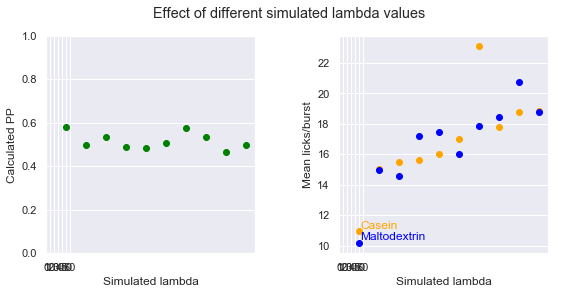

In [61]:
# Code to run simulations with different lambda values

histbins = np.arange(0,100)

lam_array = np.arange(50,550,50)
PP = 0.5

realPP_array = []
casbursts_array = []
maltbursts_array = []

for lam in lam_array: 
    # ratkey = 'simulated_PP={0}_lambda={1}'.format(PP,lam)
    licks = runmodel(PP, lam, 5000)
    lickdata = analyse_licks(licks, histbins)
    
    realPP_array.append(lickdata['realPP'])
    
    casbursts_array.append(np.mean(lickdata['bursts'][1]))
    maltbursts_array.append(np.mean(lickdata['bursts'][0]))
    
f, ax = plt.subplots(figsize=(9,4), ncols=2)
f.subplots_adjust(wspace=0.4)
f.suptitle('Effect of different simulated lambda values')

ax[0].plot(lam_array, realPP_array, 'o', color='green')

ax[1].plot(lam_array, casbursts_array, 'o', color='orange')
ax[1].plot(lam_array, maltbursts_array, 'o', color='blue')

for axis in [ax[0], ax[1]]:
    axis.set_xlabel('Simulated lambda')
    axis.set_xticks([0, 10, 20, 30, 40, 50, 60])
    
ax[0].set_ylabel('Calculated PP')
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

ax[1].set_ylabel('Mean licks/burst')
#ax[1].set_yticks([0, 2, 4, 6, 8, 10])
ax[1].text(0.1, 0.15, 'Casein', color='orange', transform=ax[1].transAxes, ha='left', va='top')
ax[1].text(0.1, 0.1, 'Maltodextrin', color='blue', transform=ax[1].transAxes, ha='left', va='top')

savefolder = 'C:\\Users\\James Rig\\Dropbox\\AbstractsAndTalks\\2019-06-12_MOAB Lick microstructure\\figs\\'
f.savefig(savefolder+'sim_lam_vals.png')

In [68]:
# Plots grid search plus max likelihood graphs    
def fit_plus_MLs(fitted, savefig=False):
    f = plt.figure(figsize=(8, 8))
    f.suptitle('Fitted data for PP={0} and lambda={1}'.format(PP, lam))
    gs = gridspec.GridSpec(2, 2, hspace=0.3, wspace=0.1)

    ax1 = f.add_subplot(gs[0, 0])
    fitted_heatmap(fitted, ax1)

    ax2 = f.add_subplot(gs[0,1], sharey=ax1)
    ML_PP(fitted, ax2)

    ax3 = f.add_subplot(gs[1,0], sharex=ax1)
    ML_lam(fitted, ax3)

# print('Estimated PP=', fitted['pp_EV'], ' and estimated lambda=', fitted['lam_EV'], ' using EV')
# print('Estimated PP=', fitted['pp_ML'], ' and estimated lambda=', fitted['lam_ML'], ' using ML')
    if savefig:
        f.savefig(savefolder+'fitted_simdata.png')
    
    return f
        


In [70]:
def fitted_heatmap(fitted, ax, plotML=True, simvals=[]):
    sns.set()
    sns.heatmap(np.log(fitted['grid']), cbar=False, ax=ax)
    
    if plotML:
        A = fitted['pp_marglik']
        y = np.where(A == np.amax(A))[0]+0.5
        ax.plot([0,20], [y, y], color='w')
        
        B = fitted['lam_marglik']
        x = np.where(B == np.amax(B))[0]+0.5
        ax.plot([x, x], [0,20], color='w')
        
    if len(simvals) == 2:
        x = np.where(simvals[1] == boundbins[1])[0] #need to be able to index for vals not included as boundbins
        y = np.where(simvals[0] == boundbins[0])[0]
        ax.plot(x, y+0.5, '+', color='black')
    
    ax.set_ylim([0, 19])
    ax.set_yticks(np.arange(0.5, 19, 2))
    ax.set_yticklabels(pp_vals, rotation=0)

    ax.set_xticks(np.arange(0.5, 21, 2))
    ax.set_xticklabels(lam_vals)

    ax.set_xlabel('lambda')
    ax.set_ylabel('PP')
    
    mpl.rcParams.update(my_params)

def ML_PP(fitted, ax):
    
    ax.plot(fitted['pp_marglik'], np.arange(0.5,19.5,1))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([])
    
def ML_lam(fitted, ax):
    
    ax.plot(np.arange(0.5,20.5,1),fitted['lam_marglik'])
    ax.set_xlabel('lambda')
    ax.set_yticks([])

<Figure size 432x288 with 0 Axes>

Extracted licks from Med data
PR dict_keys(['IPP3.3', 'IPP3.4', 'IPP3.7', 'IPP3.8', 'IPP3.11', 'IPP3.12'])
NR dict_keys(['IPP3.1', 'IPP3.2', 'IPP3.5', 'IPP3.6', 'IPP3.9', 'IPP3.10'])
Fitting data using bounds provided.


C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in longlong_scalars
C:\ProgramData\Anaconda3\envs\lickmodel\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in longlong_scalars


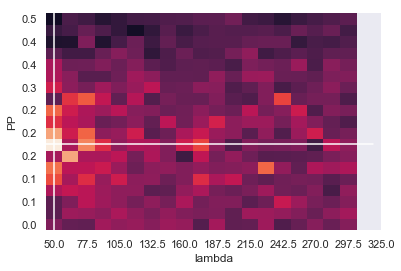

In [83]:
# Running real rats to fit to model

# for extracting real data
%run extractlicks.ipynb

print('PR', test1_data_PR.keys())
print('NR', test1_data_NR.keys())

ratkey = 'IPP3.10'
licks = test1_data_NR[ratkey]
lickdata = analyse_licks(licks, histbins)
nruns = len(lickdata['licks'])

#p1_vals = ["{:.0f}".format(x+0.05) for x in param_alpha['boundbins']]
#p2_vals = ["{:.1f}".format(x) for x in param_beta['boundbins']]

fitted = fit(lickdata, boundbins, histbins, nruns=nruns, fittype='cumsums')

f, ax = plt.subplots()
fitted_heatmap(fitted, ax, plotML=True)

#fit_plus_MLs(fitted)